In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   Unnamed: 0       image_id  \
0           0  Tumor- (1044)   
1           1    Tumor- (83)   
2           2   Tumor- (580)   
3           3  Tumor- (1701)   
4           4  Tumor- (1220)   

                                                path   diag  target  Class  
0  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
1  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
2  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
3  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
4  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  obje

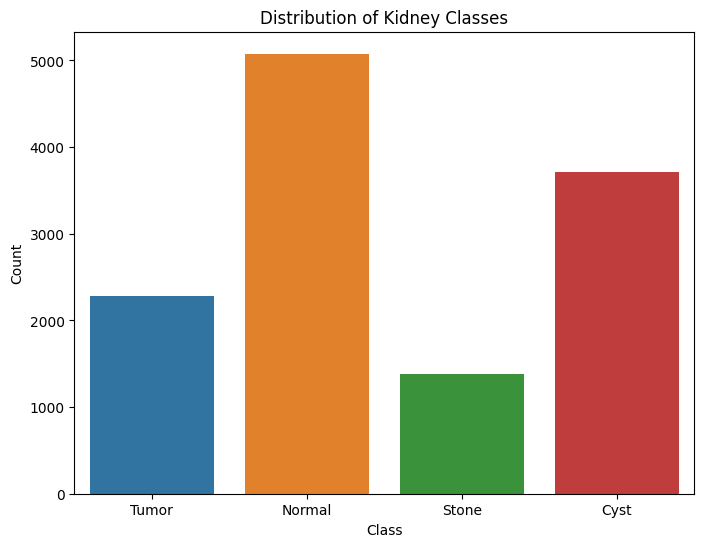

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')

# Check the first few rows of the dataset
print(df.head())

# Examine the data info (columns and datatypes)
print(df.info())

# Visualizing the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Class')  # Assuming 'class' is the column with categories
plt.title('Distribution of Kidney Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualizing the distribution of numerical features for each class


# Correlation heatmap for numerical features



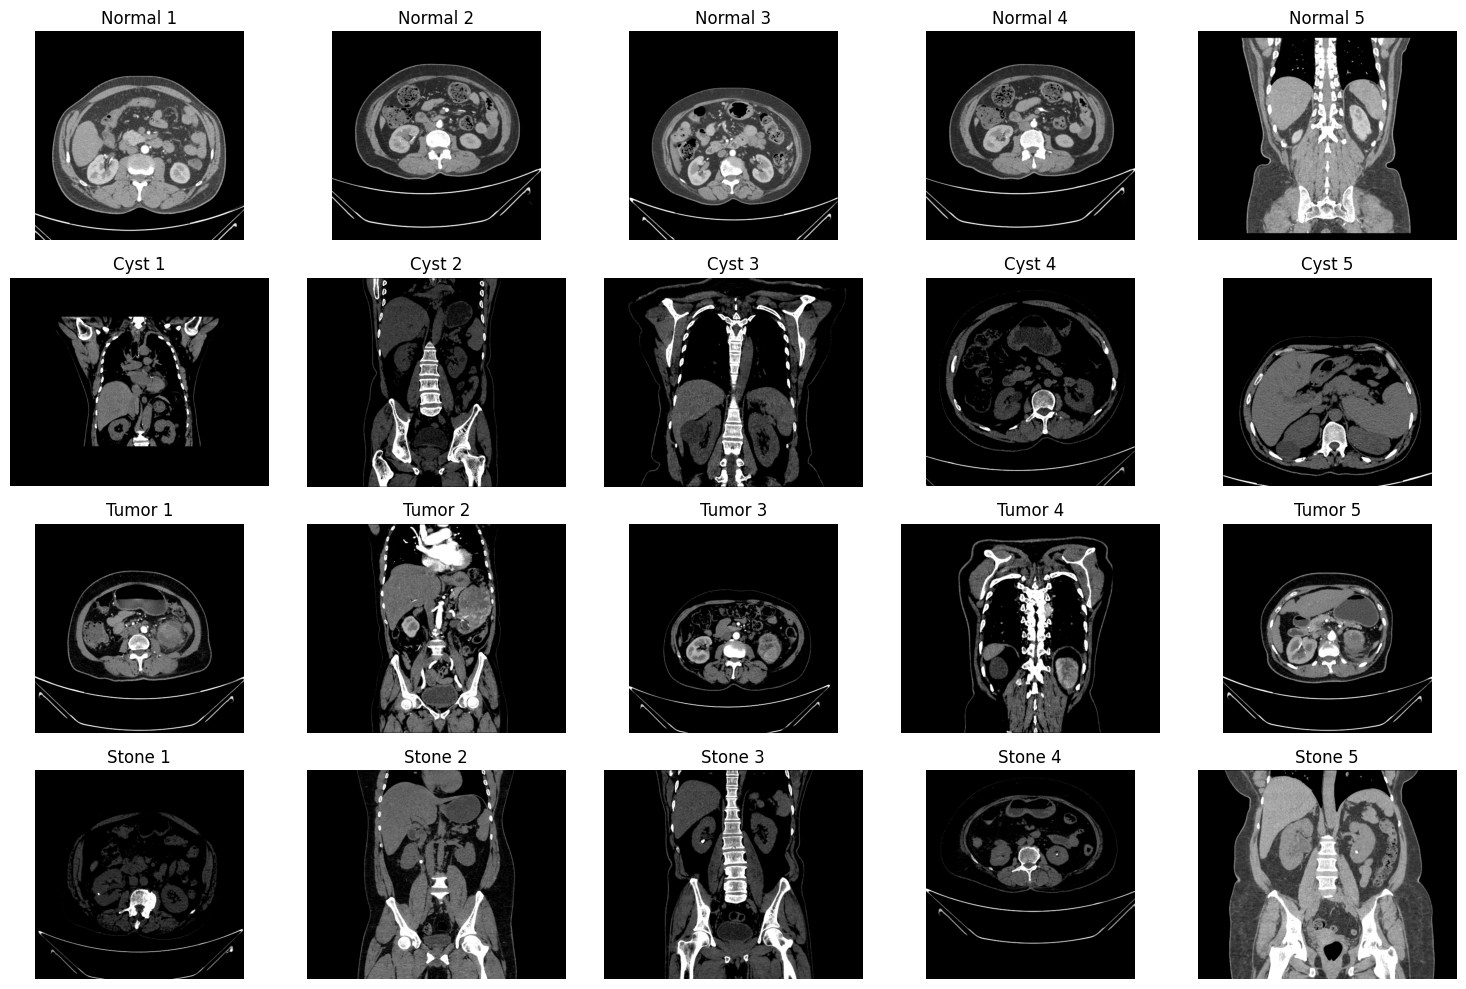

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory paths for each class
base_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Set up the plot grid
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))

# Loop through each class and display 5 sample images
for i, class_name in enumerate(classes):
    class_path = os.path.join(base_path, class_name)
    
    # Get all image file paths in the directory for the current class
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly select 5 image files
    sample_images = random.sample(image_files, 5)
    
    for j, image_file in enumerate(sample_images):
        # Load the image
        img = mpimg.imread(os.path.join(class_path, image_file))
        
        # Display the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide axes
        axes[i, j].set_title(f'{class_name} {j + 1}')
        
plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Load the dataset
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Add Transfer Learning with Pre-trained Model
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet", 
    input_shape=(img_height, img_width, 3)
)

# Convert grayscale input to RGB
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(3, (1, 1), activation="relu")(inputs)

# Use the pre-trained model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add custom layers
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

# Evaluate the model
val_preds = model.predict(val_data)
val_labels = val_data.classes

# One-hot encode labels for evaluation
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=4)

print("Classification Report:")
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Calculate AUROC
val_auroc = roc_auc_score(val_labels_onehot, val_preds, multi_class="ovr")
print(f"AUROC: {val_auroc:.4f}")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 218s 253ms/step - accuracy: 0.7626 - loss: 0.7409 - val_accuracy: 0.4757 - val_loss: 11.0975
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9665 - loss: 0.1025 - val_accuracy: 0.5782 - val_loss: 2.7576
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.4600 - val_loss: 8.9351
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9809 - loss: 0.0642 - val_accuracy: 0.4914 - val_loss: 3.5422
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9884 - loss: 0.0428 - val_accuracy: 0.6920 - val_loss: 1.8989
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 116s 185ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.6244 - val_loss: 2.6921
Epoch 7/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9982 - loss: 0.0083 - val_accuracy: 0.5521 - val_loss: 4.4886
Epoch 8/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.9941 - loss: 0.0

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Load the dataset
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255  # Normalize pixel values to [0, 1]
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Add Transfer Learning with Pre-trained Model
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet", 
    input_shape=(img_height, img_width, 3)
)

# Convert grayscale input to RGB
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(3, (1, 1), activation="relu")(inputs)

# Use the pre-trained model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add custom layers
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Evaluate the model
val_preds = model.predict(val_data)
val_labels = val_data.classes

# One-hot encode labels for evaluation
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=4)

print("Classification Report:")
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Calculate AUROC
val_auroc = roc_auc_score(val_labels_onehot, val_preds, multi_class="ovr")
print(f"AUROC: {val_auroc:.4f}")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 186s 219ms/step - accuracy: 0.3856 - loss: 1.3877 - val_accuracy: 0.4081 - val_loss: 1.2949
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 114s 181ms/step - accuracy: 0.4140 - loss: 1.2844 - val_accuracy: 0.4081 - val_loss: 43.1788
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.4065 - loss: 1.2929 - val_accuracy: 0.4081 - val_loss: 477.7419
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.4023 - loss: 1.2910 - val_accuracy: 0.4081 - val_loss: 1616.1552
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.4112 - loss: 1.2847 - val_accuracy: 0.4081 - val_loss: 541.2519
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.4096 - loss: 1.2880 - val_accuracy: 0.4081 - val_loss: 567.2794
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.41      1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Load the dataset
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=5  # Normalize pixel values to [0, 1]
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Add Transfer Learning with Pre-trained Model
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet", 
    input_shape=(img_height, img_width, 3)
)

# Convert grayscale input to RGB
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(3, (1, 1), activation="relu")(inputs)

# Use the pre-trained model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add custom layers
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Evaluate the model
val_preds = model.predict(val_data)
val_labels = val_data.classes

# One-hot encode labels for evaluation
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=4)

print("Classification Report:")
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Calculate AUROC
val_auroc = roc_auc_score(val_labels_onehot, val_preds, multi_class="ovr")
print(f"AUROC: {val_auroc:.4f}")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 196s 233ms/step - accuracy: 0.7268 - loss: 0.8486 - val_accuracy: 0.8158 - val_loss: 0.6376
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 195ms/step - accuracy: 0.9457 - loss: 0.1670 - val_accuracy: 0.6325 - val_loss: 1.9089
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9703 - loss: 0.0918 - val_accuracy: 0.6417 - val_loss: 1.8696
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9810 - loss: 0.0530 - val_accuracy: 0.7334 - val_loss: 1.7585
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9926 - loss: 0.0283 - val_accuracy: 0.5440 - val_loss: 7.0169
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9797 - loss: 0.0639 - val_accuracy: 0.7041 - val_loss: 1.9589
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.33      0.31       741
           1       0.40      0.35      0.38

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Load the dataset
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=10  # Normalize pixel values to [0, 1]
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Add Transfer Learning with Pre-trained Model
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet", 
    input_shape=(img_height, img_width, 3)
)

# Convert grayscale input to RGB
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(3, (1, 1), activation="relu")(inputs)

# Use the pre-trained model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add custom layers
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Evaluate the model
val_preds = model.predict(val_data)
val_labels = val_data.classes

# One-hot encode labels for evaluation
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=4)

print("Classification Report:")
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Calculate AUROC
val_auroc = roc_auc_score(val_labels_onehot, val_preds, multi_class="ovr")
print(f"AUROC: {val_auroc:.4f}")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 196s 234ms/step - accuracy: 0.7131 - loss: 0.8608 - val_accuracy: 0.5645 - val_loss: 4.1595
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9242 - loss: 0.2238 - val_accuracy: 0.5111 - val_loss: 3.2416
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 195ms/step - accuracy: 0.9621 - loss: 0.1214 - val_accuracy: 0.8058 - val_loss: 1.1548
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9849 - loss: 0.0566 - val_accuracy: 0.5879 - val_loss: 2.6884
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9768 - loss: 0.0802 - val_accuracy: 0.5589 - val_loss: 2.6287
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9883 - loss: 0.0413 - val_accuracy: 0.7652 - val_loss: 1.1559
Epoch 7/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9873 - loss: 0.0415 - val_accuracy: 0.5517 - val_loss: 3.5495
Epoch 8/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9836 - loss: 0.05

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Load the dataset
data_dir = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20  # Normalize pixel values to [0, 1]
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

# Add Transfer Learning with Pre-trained Model
base_model = tf.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet", 
    input_shape=(img_height, img_width, 3)
)

# Convert grayscale input to RGB
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(3, (1, 1), activation="relu")(inputs)

# Use the pre-trained model
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)

# Add custom layers
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Evaluate the model
val_preds = model.predict(val_data)
val_labels = val_data.classes

# One-hot encode labels for evaluation
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes=4)

print("Classification Report:")
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Calculate AUROC
val_auroc = roc_auc_score(val_labels_onehot, val_preds, multi_class="ovr")
print(f"AUROC: {val_auroc:.4f}")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


623/623 ━━━━━━━━━━━━━━━━━━━━ 195s 234ms/step - accuracy: 0.7409 - loss: 0.7682 - val_accuracy: 0.3004 - val_loss: 5.7871
Epoch 2/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9328 - loss: 0.1933 - val_accuracy: 0.6506 - val_loss: 2.8709
Epoch 3/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9662 - loss: 0.1007 - val_accuracy: 0.8002 - val_loss: 1.4369
Epoch 4/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9787 - loss: 0.0672 - val_accuracy: 0.3518 - val_loss: 5.0903
Epoch 5/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9784 - loss: 0.0632 - val_accuracy: 0.6582 - val_loss: 1.5659
Epoch 6/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9822 - loss: 0.0655 - val_accuracy: 0.6446 - val_loss: 3.4200
Epoch 7/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9826 - loss: 0.0582 - val_accuracy: 0.7973 - val_loss: 0.9559
Epoch 8/20
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.9818 - loss: 0.06

In [16]:
!pip install tensorflow_quantum

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 99.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
